### SQLITE


In [22]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("pythonsqlite.db")
df = pd.read_sql_query("select * from otomoto_20200330;", conn)
df.head(5)

df2 = pd.read_sql_query("select * from otomoto_20200331 limit 15;", conn)

df3 = pd.read_sql_query("select * from car_ID6zTdC2;", conn)


In [31]:
df.head(3)

,offer_id,uid,url,city,type,year,mileage,price,currency
0,6005738641,ID6yrsYh,https://www.otomoto.pl/oferta/toyota-yaris-1-0...,Kraków,Toyota Yaris II,2009,111000,6200,PLN
1,6018694885,ID6zjPtX,https://www.otomoto.pl/oferta/toyota-yaris-sal...,Olsztynek,Toyota Yaris II,2008,45706,4700,PLN
2,6025678407,ID6zN8dp,https://www.otomoto.pl/oferta/toyota-yaris-1-3...,Milanówek,Toyota Yaris II,2009,174000,19800,PLN


In [24]:
df2.head(3)

,offer_id,uid,url,city,type,year,mileage,price,currency
0,6005738641,ID6yrsYh,https://www.otomoto.pl/oferta/toyota-yaris-1-0...,Kraków,Toyota Yaris II,2009,111000,6200,PLN
1,6018694885,ID6zjPtX,https://www.otomoto.pl/oferta/toyota-yaris-sal...,Olsztynek,Toyota Yaris II,2008,45706,4700,PLN
2,6025678407,ID6zN8dp,https://www.otomoto.pl/oferta/toyota-yaris-1-3...,Milanówek,Toyota Yaris II,2009,174000,19800,PLN


In [25]:
df3.head()

,offer_id,user_id,UID,private_business,region,subregion,city,make,model,year,...,body_type,door_count,nr_seats,color,features,price_raw,currency,country_origin,registration,date
0,6027129122,2232019,ID6zTdC2,business,dolnoslaskie,strzegom,strzegom,toyota,yaris,2009,...,city-car,5,5,red,abs cd central-lock front-electric-windows ele...,14900,0,d,0,2020-03-31
1,6027129122,2232019,ID6zTdC2,business,dolnoslaskie,strzegom,strzegom,toyota,yaris,2009,...,city-car,5,5,red,abs cd central-lock front-electric-windows ele...,14900,0,d,0,2020-03-31


In [21]:
df3.columns

Index(['offer_id', 'user_id', 'UID', 'private_business', 'region', 'subregion',
       'city', 'make', 'model', 'year', 'mileage', 'engine_code',
       'engine_capacity', 'vin', 'fuel_type', 'engine_power', 'gearbox',
       'transmission', 'body_type', 'door_count', 'nr_seats', 'color',
       'features', 'price_raw', 'currency', 'country_origin', 'registration',
       'date'],
      dtype='object')

In [38]:
column_names = ['offer_id', 'uid', 'city','region','type','year','mileage','engine_capacity', 'vin', 'fuel_type', 'engine_power', 'gearbox',
       'transmission', 'body_type', 'door_count', 'nr_seats', 'color','features', 'price_raw', 'currency', 'country_origin', 'registration',
       'date' ]


mdf = pd.DataFrame(columns = column_names)
mdf[['offer_id', 'uid', 'city']] = df[['offer_id','uid', 'city']]
mdf['type'] = df['type']
mdf.head(3)

,offer_id,uid,city,region,type,year,mileage,engine_capacity,vin,fuel_type,...,body_type,door_count,nr_seats,color,features,price_raw,currency,country_origin,registration,date
0,6005738641,ID6yrsYh,Kraków,NaN,Toyota Yaris II,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6018694885,ID6zjPtX,Olsztynek,NaN,Toyota Yaris II,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6025678407,ID6zN8dp,Milanówek,NaN,Toyota Yaris II,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Test field

In [4]:
mylist = ['abs', 'cd', 'central-lock', 'front-electric-windows', 'electronic-rearview-mirrors', 'electronic-immobiliser', 'front-airbags', 'front-passenger-airbags', 'original-radio', 'assisted-steering', 'alarm', 'electric-exterior-mirror', 'electric-interior-mirror', 'air-conditioning', 'onboard-computer', 'front-side-airbags', 'rear-passenger-airbags', 'roof-bars', 'fog-lights', 'velour-interior']
print(' '.join(mylist))

abs cd central-lock front-electric-windows electronic-rearview-mirrors electronic-immobiliser front-airbags front-passenger-airbags original-radio assisted-steering alarm electric-exterior-mirror electric-interior-mirror air-conditioning onboard-computer front-side-airbags rear-passenger-airbags roof-bars fog-lights velour-interior


In [3]:
import json 
import pandas as pd 
from pandas.io.json import json_normalize 

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

with open("y.json") as f:
    d = json.load(f)

print(d['title'])    
print(d['features'])
    
flat = flatten_json(d)


yaris = json_normalize(d)
yaris.head(3)

toyota yaris 1 3 serwisowany
['abs', 'cd', 'central-lock', 'front-electric-windows', 'electronic-rearview-mirrors', 'electronic-immobiliser', 'front-airbags', 'front-passenger-airbags', 'original-radio', 'assisted-steering', 'esp', 'isofix', 'air-conditioning', 'onboard-computer', 'side-window-airbags', 'heated-rearview-mirrors', 'driver-knee-airbag', 'front-side-airbags', 'rear-passenger-airbags', 'alarm', 'mp3', 'rear-parking-sensors']


,title,offer_seek,private_business,category,region,subregion,ad_id,city,make,model,...,door_count,nr_seats,color,features,price,price_raw,country_origin,user_status,sponsor_financing,env
0,toyota yaris 1 3 serwisowany,offer,private,osobowe,slaskie,raciborz,6036867722,raciborz,[toyota],[yaris],...,[5],[5],[red],"[abs, cd, central-lock, front-electric-windows...",[10000-15000],14900,[d],0,false,prod


In [17]:
type(yaris['features'].values[0])

list

In [18]:
yaris['features'].values[0]

['abs',
 'cd',
 'central-lock',
 'front-electric-windows',
 'electronic-rearview-mirrors',
 'electronic-immobiliser',
 'front-airbags',
 'front-passenger-airbags',
 'original-radio',
 'assisted-steering',
 'esp',
 'isofix',
 'air-conditioning',
 'onboard-computer',
 'side-window-airbags',
 'heated-rearview-mirrors',
 'driver-knee-airbag',
 'front-side-airbags',
 'rear-passenger-airbags',
 'alarm',
 'mp3',
 'rear-parking-sensors']

In [19]:
yaris.columns

Index(['title', 'offer_seek', 'private_business', 'category', 'region',
       'subregion', 'ad_id', 'city', 'make', 'model', 'year', 'mileage',
       'engine_capacity', 'fuel_type', 'engine_power', 'gearbox',
       'transmission', 'body_type', 'door_count', 'nr_seats', 'color',
       'features', 'price', 'price_raw', 'country_origin', 'user_status',
       'sponsor_financing', 'env'],
      dtype='object')

## py_otomoto

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('my_df.csv')
df.head(3)

,offer_id,city,region,model,year,mileage,fuel_type,displacement,price,currency,pub_date,duration,end_price
0,6069449316,Prudnik,Opolskie,Toyota Yaris II,2009,153000,Diesel,-1,12999,PLN,2019-12-31,7,12999
1,6068202189,Włocławek,Kujawsko-pomorskie,Toyota Yaris II,2008,110000,Benzyna,1298,17600,PLN,2019-12-31,21,16900
2,6067206317,Łódź,Łódzkie,Toyota Yaris II,2010,167938,Diesel,1364,13999,PLN,2019-12-31,31,13900


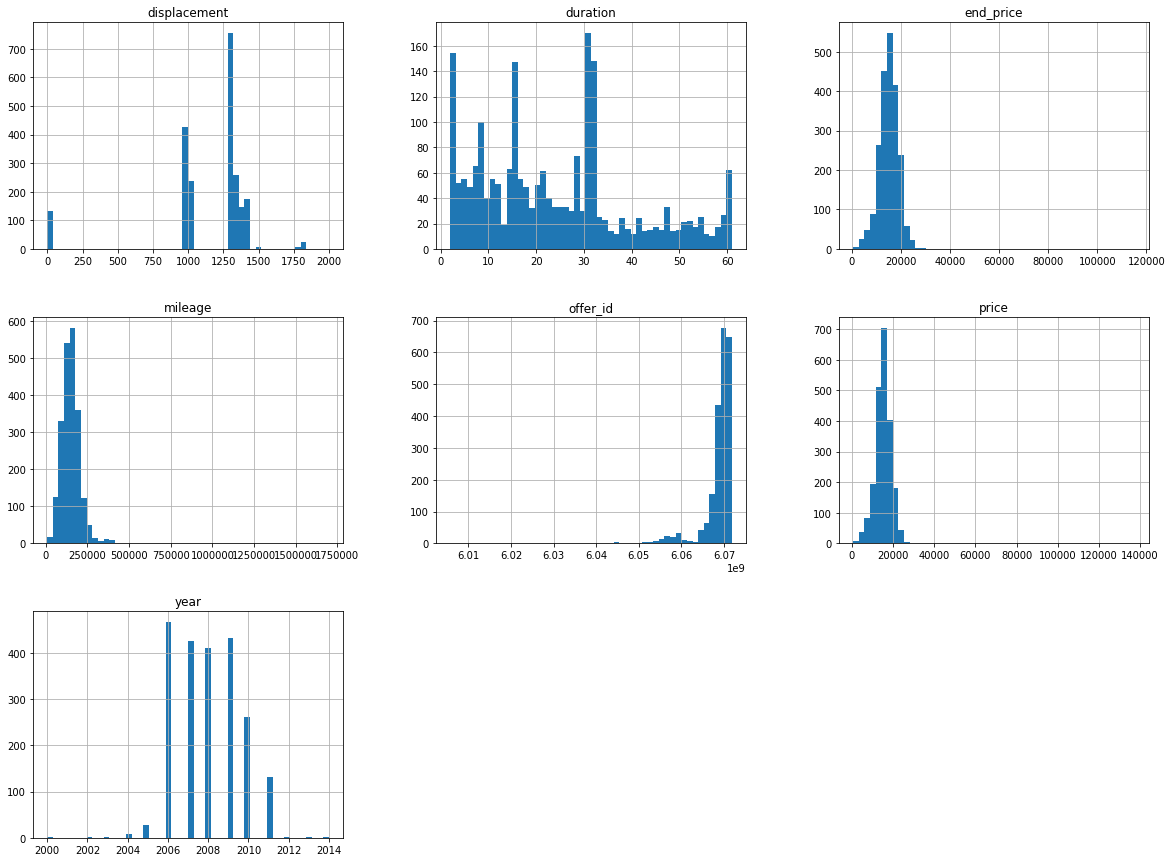

In [3]:
df.hist(bins=50,figsize=(20,15))
plt.show()

### Pojemność silnika

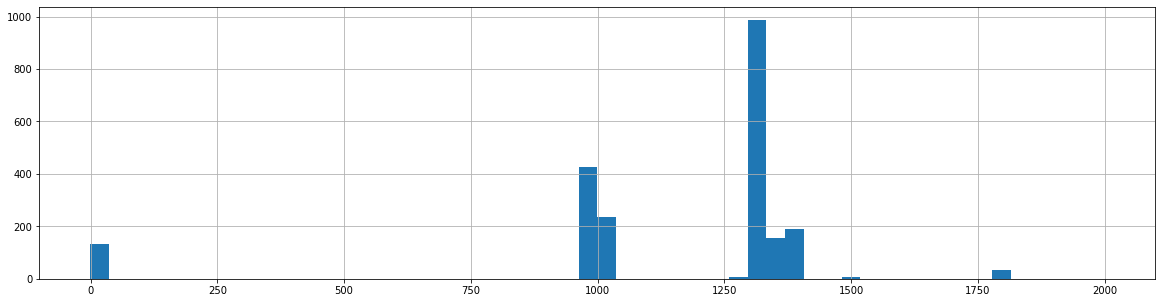

In [4]:
disp_counter = df['displacement'].nunique()
df['displacement'].hist(bins=disp_counter,figsize=(20,5))
plt.show()

### Czas trwania ogłoszenia

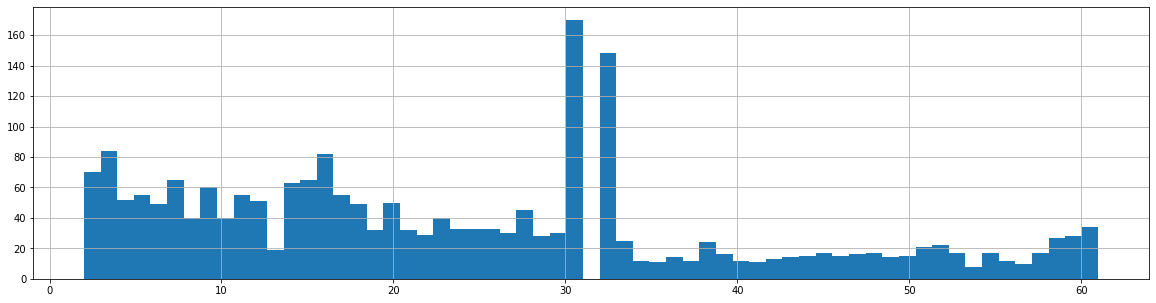

In [5]:
offer_duration = df['duration'].max()
df['duration'].hist(bins=offer_duration,figsize=(20,5))
plt.show()

### Cena końcowa

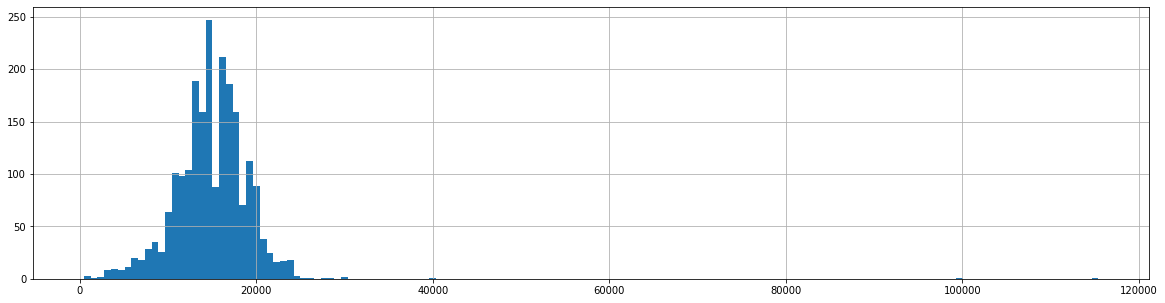

In [6]:
df['end_price'].hist(bins=150,figsize=(20,5))
plt.show()

In [7]:
filter_max = np.percentile(df['end_price'],99)
filter_max

23684.00000000006

### Cena końcowa - 99 percentyl

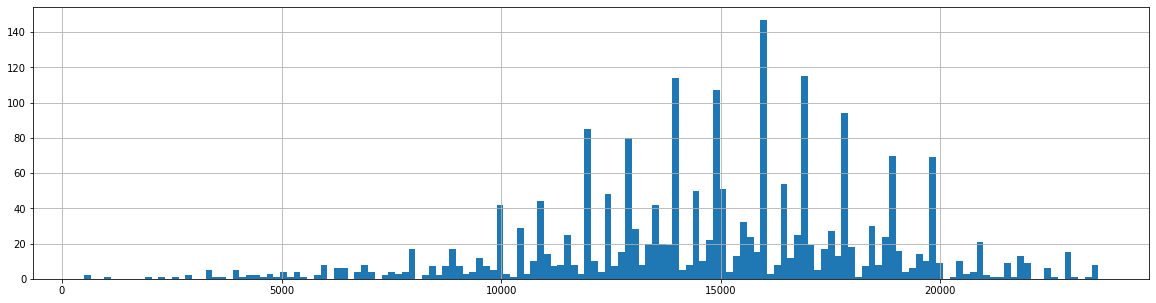

In [8]:
df_filter = df[df['end_price'] < filter_max]
df_filter['end_price'].hist(bins=150,figsize=(20,5))
plt.show()

### Przebieg

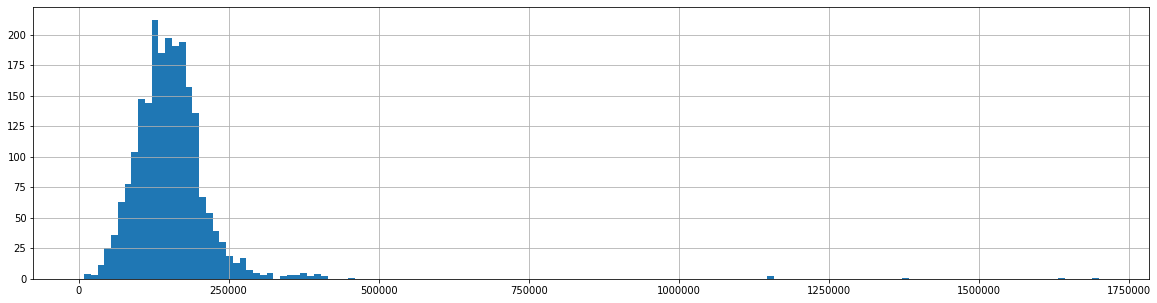

In [9]:
df['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

### Przebieg - 99 percentyl

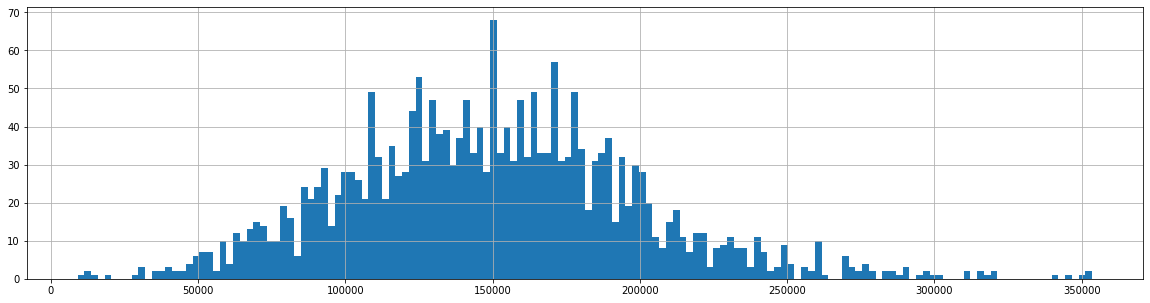

In [10]:
df_mileage = df[df['mileage'] < np.percentile(df['mileage'],99)]
df_mileage['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

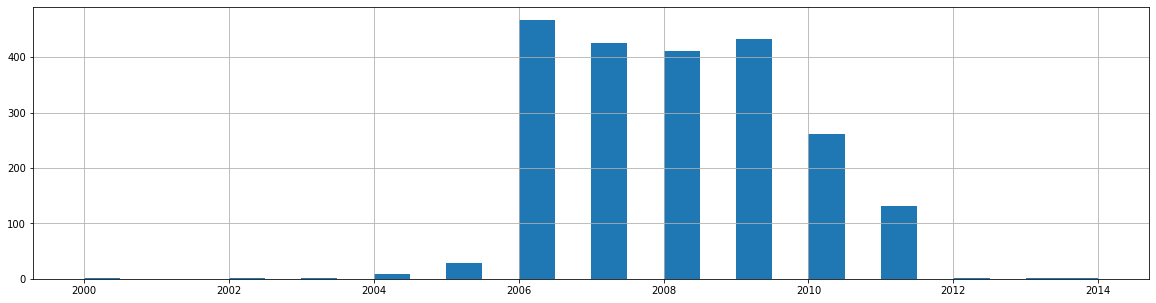

In [11]:
offer_year = df['year'].nunique()*2
df['year'].hist(bins=offer_year,figsize=(20,5))
plt.show()

In [12]:
# TODO:
# Różnica price - endprice
